#Create Dummy Training Data


Our data consists of a single random colored circle of random radius and random centers. The objective of this model is to draw a bounding box around the data

In [39]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def GenShapeImages( Num, ImgShape=(250,250,3) ):
  ImgList = []
  BBoxList = []
  color = [(255,0,0),(0,255,0),(0,0,255)]
  for idx in range(Num):
    img = np.ones(ImgShape,dtype=np.uint8)
    img = img * 255

    Rad = random.randint(0,80)
    xc = random.randint( Rad+10, ImgShape[0]-Rad-10 )
    yc = random.randint( Rad+10, ImgShape[1]-Rad-10 )

    cv2.circle(img, (xc,yc), Rad, random.choice(color), 3)
    ImgList.append(img)

    bbox =np.array( [xc-Rad-6, yc-Rad-6, xc+Rad+6, yc+Rad+6 ],dtype=np.float32 )
    bbox = bbox/250.0
    print(bbox)
    BBoxList.append(bbox)
  return ImgList, BBoxList


In [48]:
# Generate Data
train_img,train_box = GenShapeImages(500)
val_img, val_box = GenShapeImages(100)
len(train_img),len(train_box),len(val_img),len(val_box)

(500, 500, 100, 100)

In [24]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [41]:
circle_train_dataset = tf.data.Dataset.from_tensor_slices((train_img,train_box))
circle_train_dataset = circle_train_dataset.batch(32)
len(circle_train_dataset)

16

In [42]:
circle_val_dataset = tf.data.Dataset.from_tensor_slices((val_img,val_box))
circle_val_dataset = circle_val_dataset.batch(32)
len(circle_val_dataset)

4

# Visualize a Random Sample

In [53]:
def ViewImageBatch( DataSet, BatchNum=0 ):
  for Element in DataSet.skip(BatchNum).take(1):
    idx = random.randint(0,31)
    plt.imshow(Element[0][idx,:,:,:].numpy())
    plt.axis(False)

    bbox = ((Element[1][idx,:].numpy())*250).astype(np.uint32)
    print(bbox)
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]

    ax = plt.gca()
    rect = patches.Rectangle((xmin, ymin),(xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='y', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)


[ 75  29 173 127]


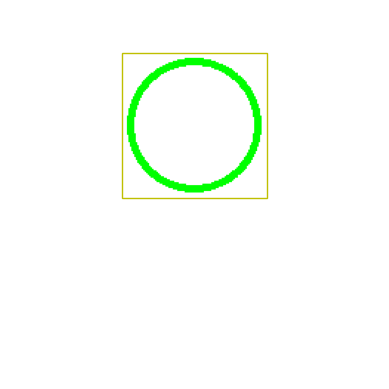

In [54]:
ViewImageBatch(circle_train_dataset,0)

#Lets Try to Model it

We'll just use a basic VGG like Convolutional Neural Network

In [55]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(250,250,3)),
    tf.keras.layers.Rescaling(1/255.), # Normalization- > divide all data by 255
    tf.keras.layers.Conv2D(60,3,activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(60,3,activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(60,3,activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(60,3,activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(64,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(32,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4,activation=tf.keras.activations.sigmoid),
])

model.compile( loss=tf.keras.losses.mae,
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['mae'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 250, 250, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 248, 248, 60)        │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 246, 246, 60)        │          32,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 123, 123, 60)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 121, 121, 60)        │          32,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 119, 119, 60)        │          32,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 59, 59, 60)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 208860)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │      26,734,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,843,736 (102.40 MB)

 Trainable params: 26,843,736 (102.40 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
hist = model.fit(circle_train_dataset, epochs=20,validation_data=circle_val_dataset)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 464ms/step - loss: 0.2273 - mae: 0.2273 - val_loss: 0.1741 - val_mae: 0.1741
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.1640 - mae: 0.1640 - val_loss: 0.0999 - val_mae: 0.0999
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - loss: 0.0903 - mae: 0.0903 - val_loss: 0.0737 - val_mae: 0.0737
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - loss: 0.0727 - mae: 0.0727 - val_loss: 0.0598 - val_mae: 0.0598
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0546 - mae: 0.0546 - val_loss: 0.0637 - val_mae: 0.0637
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - loss: 0.0515 - mae: 0.0515 - val_loss: 0.0535 - val_mae: 0.0535
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.0461 - mae: 0.0461 - val_loss: 0.0541 - val_mae: 0.0541
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0438 - mae: 0.0438 - val_loss: 0.0515 - val_mae: 0.0515
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - l

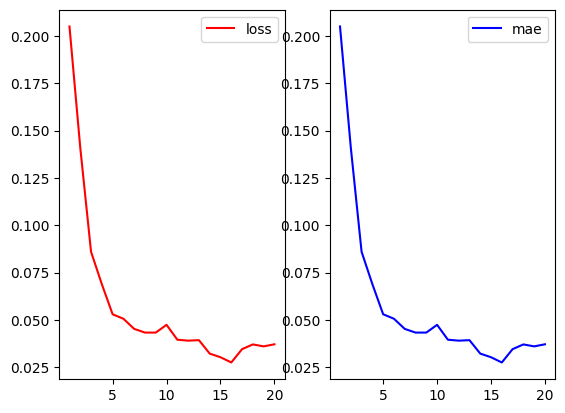

In [58]:
# plot training curves
epochs = np.arange(1,21,1)
plt.subplot(1,2,1)
plt.plot(epochs,hist.history['loss'],label='loss',color='r')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs,hist.history['mae'],label='mae',color='b')
plt.legend()

# Evaluate and Visualize a Random Sample ?

Generare Random circle images like before and see how the bounding box comes out from the Neural predictor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


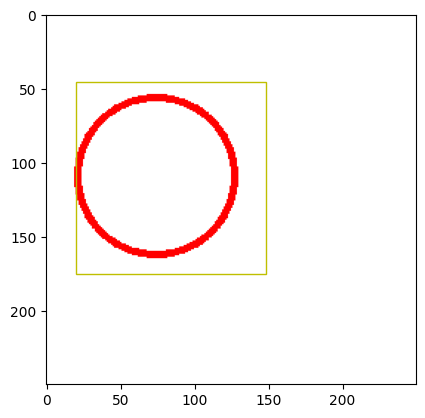

In [105]:
test, label = GenShapeImages( 1 )
plt.imshow(test[0])
pred = model.predict(tf.expand_dims(test[0],axis=0))
bbox=(pred[0]*255).astype(np.uint32)
xmin = bbox[0]
ymin = bbox[1]
xmax = bbox[2]
ymax = bbox[3]
ax = plt.gca()
rect = patches.Rectangle((xmin, ymin),(xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='y', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

#draw our prediction
